# 04 – Remaining Useful Life (RUL) Estimation

We estimate cycle count at which capacity falls below 80% of nominal.
We compare:
1) Physics-based extrapolation (sqrt model)
2) Feature-based ML regression (Random Forest)
3) Sequence model (LSTM)


In [1]:
import sys
from pathlib import Path
PROJECT_ROOT = Path("..").resolve()
sys.path.insert(0, str(PROJECT_ROOT))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.rul_models import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam


In [2]:
cycle_df = pd.read_csv("../data/filtered_cycle_features.csv")
cycle_df.head()

,cell_id,Cycle,C_rate_mean,C_rate_max,Charge_Ah,Discharge_Ah,Coulombic_Efficiency_%,Cycle_Duration_s,Energy_Throughput_Wh,Temp_Min_C,Temp_Mean_C,Temp_Max_C,Num_points,Delta_Q
0,Cell_1,3,1.934738,2.404,1.647,1.644,99.817851,3064.0,12.371862,NaN,NaN,NaN,3036,-0.018
1,Cell_1,4,1.927172,2.404,1.633,1.627,99.632578,3043.0,12.263728,NaN,NaN,NaN,3008,-0.017
2,Cell_1,5,1.923338,2.404,1.625,1.621,99.753846,3031.0,12.204228,NaN,NaN,NaN,3014,-0.006
3,Cell_1,6,1.923510,2.404,1.607,1.601,99.626633,3004.0,12.060152,NaN,NaN,NaN,2990,-0.020
4,Cell_1,7,1.918332,2.404,1.598,1.590,99.499374,2988.0,11.990072,NaN,NaN,NaN,2958,-0.011


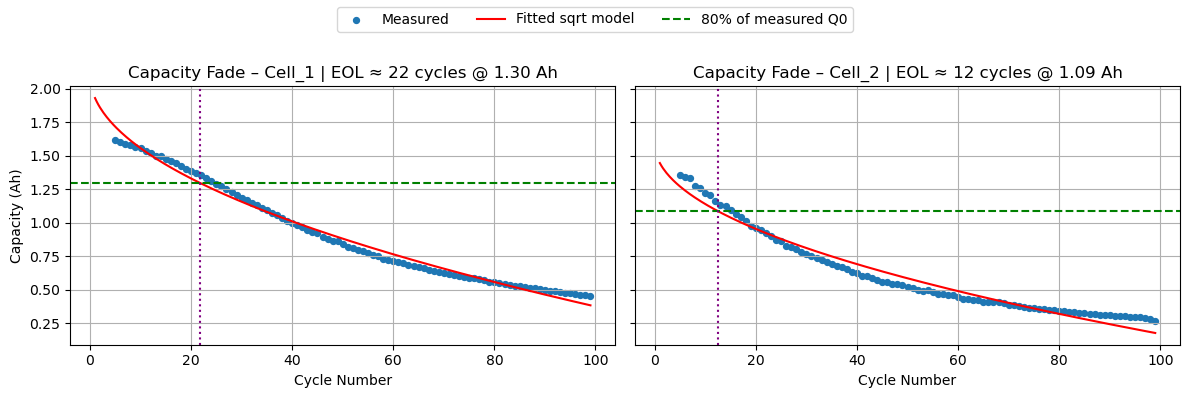

In [3]:
cell_ids = cycle_df["cell_id"].unique()
results = []

fig, axes = plt.subplots(
    1,
    len(cell_ids),
    figsize=(6 * len(cell_ids), 4),
    sharey=True
)

# Ensure axes is iterable
if len(cell_ids) == 1:
    axes = [axes]

for ax, cid in zip(axes, cell_ids):

    # === Fit model and compute RUL ===
    res = fit_square_root_and_rul_for_cell(
        cycle_df,
        cid,
        use_mid_life=True
    )
    results.append(res)

    n = res["n"]                 # cycle index array
    Q = res["Q"]                 # measured capacity
    Q0_meas = res["Q0_meas"]     # measured initial capacity
    Q0_fit = res["Q0_fit"]       # fitted initial capacity
    a_fit = res["a_fit"]         # sqrt coefficient
    Q_EOL = res["Q_EOL"]         # 80% capacity threshold
    n_eol = res["n_eol"]         # predicted EOL cycle

    # === Prepare model curve for plotting ===
    n_max_plot = int(max(n.max(), n_eol))
    n_plot = np.linspace(1, n_max_plot, 300)   # 🔧 FIX: avoid sqrt(0)
    Q_plot = model_square_root(n_plot, Q0_fit, a_fit)

    # === Plot measured data ===
    ax.scatter(
        n,
        Q,
        s=18,
        label="Measured"
    )

    # === Plot fitted sqrt model ===
    ax.plot(
        n_plot,
        Q_plot,
        "r",
        label="Fitted sqrt model"
    )

    # === Plot 80% capacity threshold ===
    ax.axhline(
        Q_EOL,
        color="green",
        linestyle="--",
        label="80% of measured Q0"
    )

    # === Plot EOL vertical line ===
    ax.axvline(
        n_eol,
        color="purple",
        linestyle=":",
    )

    # === FIXED TITLE (EOL SHOWN CLEARLY) ===
    n_eol_disp = int(round(n_eol)) if np.isfinite(n_eol) else None

    if n_eol_disp is None:
        ax.set_title(f"Capacity Fade – {cid} (EOL: N/A)")
    else:
        ax.set_title(
            f"Capacity Fade – {cid} | "
            f"EOL ≈ {n_eol_disp} cycles @ {Q_EOL:.2f} Ah"
        )

    ax.set_xlabel("Cycle Number")
    ax.grid(True)

# === Shared Y label ===
axes[0].set_ylabel("Capacity (Ah)")

# === Single global legend ===
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    ncol=4
)

plt.tight_layout(rect=[0, 0, 1, 0.88])
plt.show()


#### Sequence model LSTM

In [4]:
# --- LSTM config ---
seq_len = 10  # number of past cycles shown to LSTM

# 1) Start with *base* features (without cycle_norm)
base_feature_cols = [
    "Discharge_Ah",
    "C_rate_mean",
    "Energy_Throughput_Wh",
    "Coulombic_Efficiency_%"
]

# Make sure there are no NaNs in these base features
df_lstm = cycle_df.dropna(subset=base_feature_cols).copy()
df_lstm = df_lstm.sort_values(["cell_id", "Cycle"])

# 2) Add normalized cycle index (0..1 per cell)
df_lstm["cycle_norm"] = df_lstm.groupby("cell_id")["Cycle"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# 3) Now define the full feature list including cycle_norm
feature_cols_lstm = base_feature_cols + ["cycle_norm"]

# 4) Scale features (no warnings, using DataFrame)
scaler = StandardScaler()
df_lstm[feature_cols_lstm] = scaler.fit_transform(df_lstm[feature_cols_lstm])

In [5]:
# Build sequences for LSTM
X_list = []
y_list = []

for cell_id, g in df_lstm.groupby("cell_id"):
    g = g.sort_values("Cycle")

    data = g[feature_cols_lstm].values      # (n_cycles, n_features)
    target = g["Discharge_Ah"].values      # scaled capacity

    n_cycles = len(g)
    if n_cycles <= seq_len:
        continue

    for i in range(n_cycles - seq_len):
        X_list.append(data[i : i + seq_len, :])
        y_list.append(target[i + seq_len])

X_lstm = np.array(X_list)
y_lstm = np.array(X_list, dtype=float)  # <-- small fix: should be y_list
X_lstm = np.array(X_list)
y_lstm = np.array(y_list)

print("X_lstm shape:", X_lstm.shape)
print("y_lstm shape:", y_lstm.shape)

X_train, X_val, y_train, y_val = train_test_split(
    X_lstm, y_lstm,
    test_size=0.2,
    random_state=42,
    shuffle=True,
)

num_features = len(feature_cols_lstm)

model_lstm = Sequential([
    LSTM(64, input_shape=(seq_len, num_features)),
    Dense(32, activation="relu"),
    Dense(1)
])

model_lstm.compile(optimizer=Adam(learning_rate=1e-3), loss="mse")

history = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    verbose=1
)

X_lstm shape: (174, 10, 5)
y_lstm shape: (174,)
Epoch 1/30


c:\Users\iha81kor\.conda\envs\My_spark_environment\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.8350 - val_loss: 0.4107
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4018 - val_loss: 0.2199
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2122 - val_loss: 0.1172
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0915 - val_loss: 0.0657
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0589 - val_loss: 0.0538
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0607 - val_loss: 0.0436
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0499 - val_loss: 0.0351
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0361 - val_loss: 0.0279
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0265 - val_loss: 0.0216
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0204 - val_loss: 0.0162
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0154 - val_loss: 0.0118
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0119 - val_loss: 0.0088
Epoch 13/30


In [6]:
# After cycle_df is created
cycle_df["cycle_norm"] = cycle_df.groupby("cell_id")["Cycle"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

In [7]:
eol_by_cell = {r["cell_id"]: r["n_eol"] for r in results}
eol_by_cell

{'Cell_1': 21.79561474313402, 'Cell_2': 12.439715375494535}

In [8]:
# --------------------------------------------
# Evaluate LSTM RUL prediction at multiple
# observation fractions (30%, 50%, 70% of life)
# --------------------------------------------

for frac in [0.3, 0.5, 0.7]:
    print(f"\n--- Observation Fraction = {frac*100:.0f}% of life ---")

    for r in results:
        cid = r["cell_id"]
        eol_sqrt = r["n_eol"]   # true EOL from sqrt model

        g = cycle_df[cycle_df["cell_id"] == cid].sort_values("Cycle")
        Q0_meas = g["Discharge_Ah"].max()

        lstm_res = lstm_predict_eol_from_fraction(
            cycle_df=cycle_df,
            cell_id=cid,
            model_lstm=model_lstm,
            scaler=scaler,
            feature_cols=feature_cols_lstm,
            seq_len=seq_len,
            eol_true=eol_sqrt,
            Q0_meas=Q0_meas,
            obs_frac=frac,
            frac_EOL=0.8,
            max_extra_cycles=300
        )

        print(f"Cell {cid}: True EOL = {eol_sqrt:.1f},  LSTM EOL = {lstm_res['EOL_cycle_LSTM']}")



--- Observation Fraction = 30% of life ---
Cell Cell_1: True EOL = 21.8,  LSTM EOL = 312
Cell Cell_2: True EOL = 12.4,  LSTM EOL = 14

--- Observation Fraction = 50% of life ---
Cell Cell_1: True EOL = 21.8,  LSTM EOL = 312
Cell Cell_2: True EOL = 12.4,  LSTM EOL = 14

--- Observation Fraction = 70% of life ---
Cell Cell_1: True EOL = 21.8,  LSTM EOL = 314
Cell Cell_2: True EOL = 12.4,  LSTM EOL = 14


In [10]:
results = []
for cid, g in cycle_df.groupby("cell_id"):
    Q0_fit, a_fit, n_eol = fit_square_root(g)
    results.append({"cell_id": cid, "Q0_fit": Q0_fit, "a_fit": a_fit, "n_eol": n_eol})

In [11]:
print("\n=== Early-prediction accuracy: capacity-fade extrapolation (sqrt model) ===")
for r in results:
    cid = r["cell_id"]
    n_eol_true = r["n_eol"]      # EOL from full-life fit (reference)

    for frac in [0.3, 0.5, 0.7]:
        n_eol_pred = eol_from_early_data(cycle_df, cid, frac)
        if n_eol_pred is None:
            continue
        error = n_eol_pred - n_eol_true
        rel_error = error / n_eol_true * 100

        print(
            f"Cell {cid}, using first {int(frac*100)}% of life: "
            f"pred_EOL={n_eol_pred:.1f}, true_EOL={n_eol_true:.1f}, "
            f"Δ={error:.1f} cycles ({rel_error:+.1f}%)"
        )


=== Early-prediction accuracy: capacity-fade extrapolation (sqrt model) ===
Cell Cell_1, using first 30% of life: pred_EOL=10.1, true_EOL=6.0, Δ=4.1 cycles (+67.6%)
Cell Cell_1, using first 50% of life: pred_EOL=6.3, true_EOL=6.0, Δ=0.3 cycles (+5.6%)
Cell Cell_1, using first 70% of life: pred_EOL=5.7, true_EOL=6.0, Δ=-0.3 cycles (-5.0%)
Cell Cell_2, using first 30% of life: pred_EOL=3.7, true_EOL=5.0, Δ=-1.3 cycles (-25.3%)
Cell Cell_2, using first 50% of life: pred_EOL=3.8, true_EOL=5.0, Δ=-1.2 cycles (-23.8%)
Cell Cell_2, using first 70% of life: pred_EOL=4.2, true_EOL=5.0, Δ=-0.8 cycles (-15.6%)


In [12]:
results_pd = pd.DataFrame(results)
results_pd.to_csv("../data/rul_features.csv", index=False)